In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

## 1. Hyperparameters

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
epochs=1000

## 2. Making the data ready

In [3]:
n_samples=1500

#make moons
X,y= make_moons(n_samples,
                noise=0.08,
                random_state=43)

In [4]:
#make the dataframe of the moon data to visualize
moons= pd.DataFrame({'X1':X[:,0], #all rows and first column
                     'X2':X[:,1], #all rows and second column
                      'label':y})

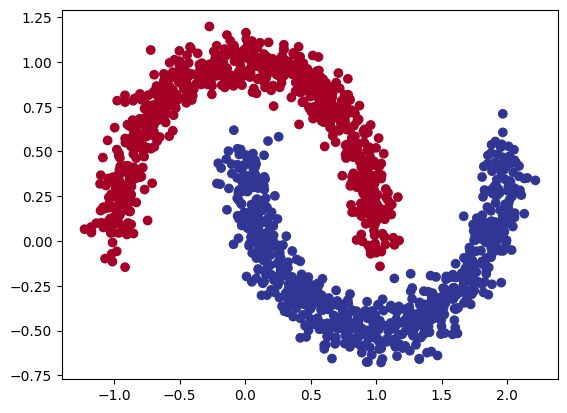

In [5]:
#visualizing the data
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
#changing the data into tensor
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

### 2.1 Splitting the data into Train test 

In [7]:
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                  random_state=42)

In [8]:
#checking the shapes 
len(X_train),len(X_test),len(y_train),len(y_test)

(1200, 300, 1200, 300)

## 3. Building the model

In [9]:
#building the model
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,   out_features=128)
        self.layer2 = nn.Linear(in_features=128, out_features=128)
        self.layer3 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    

model_1 = MoonModelV0().to(device)
model_1

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
# Defining the loss funciton
loss_func= nn.BCEWithLogitsLoss()

#creathe an optimizer
optimizer= torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [11]:
#accuracy calcualte
def accuracy_func(y_true,y_pred):
    return (torch.eq(y_true,y_pred).sum().item())/len(y_pred)

In [12]:
torch.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate the loss and accuracy
    loss = loss_func(y_logits, y_train)  # Ensure logits go into loss function
    acc = accuracy_func(y_train, y_preds)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()  # Fix here: should be loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_1.eval()

    with torch.inference_mode():  # or torch.no_grad() if using an older version
        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss and accuracy
        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_test, test_preds)

        # Log every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70442, Accuracy: 0.51% | Test loss: 0.69076, Test acc: 0.47%
Epoch: 100 | Loss: 0.20315, Accuracy: 0.91% | Test loss: 0.20432, Test acc: 0.92%
Epoch: 200 | Loss: 0.13987, Accuracy: 0.94% | Test loss: 0.14661, Test acc: 0.94%
Epoch: 300 | Loss: 0.08723, Accuracy: 0.98% | Test loss: 0.09393, Test acc: 0.97%
Epoch: 400 | Loss: 0.05241, Accuracy: 0.99% | Test loss: 0.05750, Test acc: 0.98%
Epoch: 500 | Loss: 0.03358, Accuracy: 0.99% | Test loss: 0.03711, Test acc: 0.99%
Epoch: 600 | Loss: 0.02350, Accuracy: 1.00% | Test loss: 0.02594, Test acc: 0.99%
Epoch: 700 | Loss: 0.01770, Accuracy: 1.00% | Test loss: 0.01943, Test acc: 1.00%
Epoch: 800 | Loss: 0.01407, Accuracy: 1.00% | Test loss: 0.01533, Test acc: 1.00%
Epoch: 900 | Loss: 0.01163, Accuracy: 1.00% | Test loss: 0.01256, Test acc: 1.00%


In [13]:
# make prediction
# Make predictions
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 0., 0., 1., 0., 0., 0., 1., 1.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1.]))

In [14]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

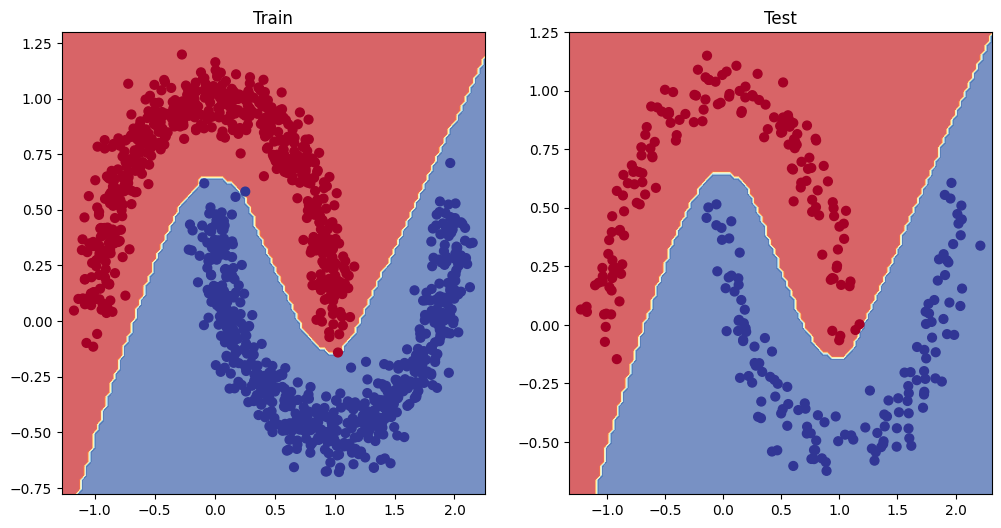

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # model_3 = has non-linearity

# Multiclas classification for spiral dataset

In [16]:
# data creation
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

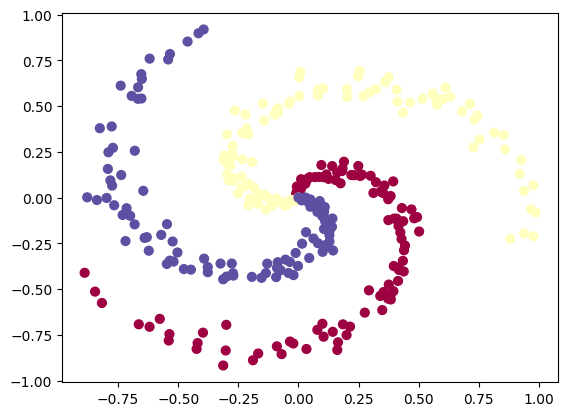

In [17]:
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [18]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [19]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [20]:
class SpiralModel(nn.Module): 
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_2 = SpiralModel().to(device)
model_2

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr=0.02)

In [22]:
# Loop over data


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  ## Training
  model_2.train()
  # 1. forward pass
  y_logits = model_2(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_2(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")
     

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.44 Acc: 0.78 | Test loss: 0.55 Test acc: 0.68
Epoch: 200 | Loss: 0.21 Acc: 0.93 | Test loss: 0.24 Test acc: 0.93
Epoch: 300 | Loss: 0.12 Acc: 0.97 | Test loss: 0.15 Test acc: 0.93
Epoch: 400 | Loss: 0.09 Acc: 0.97 | Test loss: 0.12 Test acc: 0.93
Epoch: 500 | Loss: 0.07 Acc: 0.97 | Test loss: 0.10 Test acc: 0.97
Epoch: 600 | Loss: 0.06 Acc: 0.98 | Test loss: 0.08 Test acc: 0.97
Epoch: 700 | Loss: 0.05 Acc: 0.99 | Test loss: 0.05 Test acc: 1.00
Epoch: 800 | Loss: 0.05 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 900 | Loss: 0.04 Acc: 0.99 | Test loss: 0.04 Test acc: 0.98


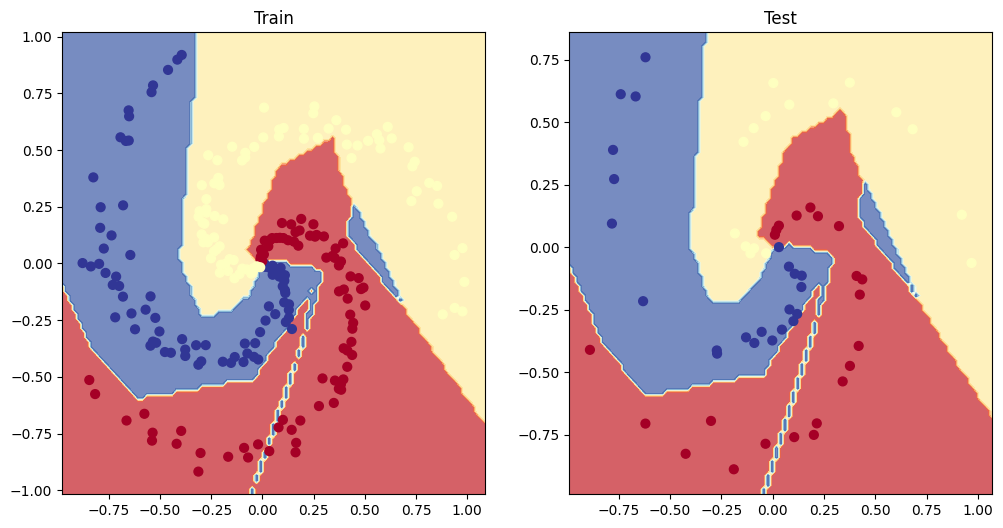

In [23]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)